# CSC321H5 Project 2.

**Deadline**: Thursday, Feb. 13, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

**Late Submission**: Please see the syllabus for the late submission criteria.

Based on an assignment by George Dahl, Jing Yao Li, and Roger Grosse

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three. 
We'll explore a couple of different models to perform this prediction task. We will also do this
problem twice: once in PyTorch, and once using numpy. When using numpy, you'll implement
the backpropagation computation.

In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [0]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from `https://www.cs.toronto.edu/~lczhang/321/hw/raw_sentences.txt`
and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [0]:
file_path = '/content/gdrive/My Drive/CSC321/raw_sentences.txt' # TODO - UPDATE ME!

You might find it helpful to know that you can run shell commands (like `ls`) by
using `!` in Google Colab, like this:

In [0]:
#!ls /content/gdrive/My\ Drive/
!ls /content/gdrive/My\ Drive/CSC321/

raw_sentences.txt


The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [0]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [0]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [0]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 2 pts

Display 10 sentences in the training set.
Explain how punctuations are treated in our word representation, and how words
with apostrophes are represented.

In [0]:
print(train[:10])
#the punctutations are treated as a seperate words.
#the words with apostrophoes are divided into two words, for example "one's" has
#been seperated into "one" and "'s".

[['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.'], ['on', 'what', 'can', 'i', 'do', '?'], ['now', 'where', 'does', 'it', 'go', '?'], ['what', 'did', 'the', 'court', 'do', '?'], ['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.'], ['that', 'was', 'the', 'only', 'way', '.'], ['this', 'team', 'will', 'be', 'back', '.'], ['so', 'that', 'is', 'what', 'i', 'do', '.'], ['we', 'have', 'a', 'right', 'to', 'know', '.'], ['now', 'they', 'are', 'three', '.']]


### Part (b) -- 2 pts

What are the 10 most common words in the vocabulary? How often does each of these
words appear in the training sentences? Express the second quantity a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are good quantities to compute, because one of the first things a machine learning
model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

In [0]:
#c = Counter(vocab)
#c.most_common(10)
#todo add percentage 
import collections
flat_list = []
for sublist in train:
    for item in sublist:
        flat_list.append(item)
y = collections.Counter(flat_list).most_common(10)
counter = 1
for tup in y:
  percent = str(int(tup[1]/len(train)*100))
  print("word"+str(counter) + " '" + tup[0]+ "' has percent " + percent + '%')
  counter +=1


word1 '.' has percent 83%
word2 'it' has percent 29%
word3 ',' has percent 25%
word4 'i' has percent 22%
word5 'do' has percent 20%
word6 'to' has percent 20%
word7 'nt' has percent 16%
word8 '?' has percent 16%
word9 'the' has percent 16%
word10 ''s' has percent 16%


### Part (c) -- 4 pts

Complete the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$$N \times 4$$ numpy matrix containing indices of 4 words that appear
next to each other. You can use the constances `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [0]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    
    new_sents = []
    for sent in sents:
      new_sent = []
      for word in sent:
        new_sent.append(vocab_stoi[word])
      new_sents.append(new_sent)
    return new_sents

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """
    four_grams = [] 
    for seq in seqs:
      length = len(seq)
      for i in range(length-3):
        s = seq[i: i+4]
        four_grams.append(s)
    return four_grams
  
def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)


## Question 2. A Multi-Layer Perceptron

In this section, we will build a two-layer multi-layer perceptron.
We will first do this in numpy, and then once more in PyTorch.
Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model1.png" />

Start by reviewing these helper functions, which are given to you:

In [0]:
def make_onehot(indicies, total=250):
    """
    Convert indicies into one-hot vectors by
        1. Creating an identity matrix of shape [total, total]
        2. Indexing the appropriate columns of that identity matrix
    """
    I = np.eye(total)
    return I[indicies]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.
    """
    x = x.T
    exps = np.exp(x - x.max(axis=0))
    probs = exps / np.sum(exps, axis=0)
    return probs.T

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xs, ts) where:
     - `xs` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `ts` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xs = data[range_min:range_max, :3]
    xs = make_onehot(xs)
    ts = data[range_min:range_max, 3]
    if onehot:
        ts = make_onehot(ts).reshape(-1, 250)
    return xs, ts

def estimate_accuracy(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        y = model(xs)
        pred = np.argmax(y, axis=1)
        correct += np.sum(ts == pred)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

### Part (a) -- 2 point

Your first task is to implement MLP model in Numpy.
This model is very similar to the one we built in Tutorial 5. However, we will
write our code differently from Tutorial 5, so that the class methods and APIs
are similar to that of PyTorch. This is to give you some intuition about what
PyTorch is doing under the hood.

We already wrote code for the backward pass for this model in Tutorial 5, so the
code is given to you. To make sure you understand how the model works, 
**write the code to compute the forward pass**.

In [0]:
class NumpyMLPModel(object):
    def __init__(self, num_features=250*3, num_hidden=400, num_classes=250):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.weights1 = np.zeros([num_hidden, num_features])
        self.bias1 = np.zeros([num_hidden])
        self.weights2 = np.zeros([num_classes, num_hidden])
        self.bias2 = np.zeros([num_classes])
        self.cleanup()

    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.weights1 = np.random.normal(0, 2/self.num_features, self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.num_features, self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden, self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.
        Note that `inputs` will be a rank-3 numpy array with shape [N, 3, 250],
        so we will need to flatten the tensor to [N, 750] first.

        For the ReLU activation, you may find the function `np.maximum` helpful
        """
        X = inputs.reshape([-1, 750])
        

        self.N = X.shape[0]
        self.X = X
        self.z1 =  np.matmul(X, self.weights1.T) + self.bias1.reshape((1, 400))
        self.h = np.maximum(0, self.z1)
        self.z2 = np.matmul(self.h, self.weights2.T) + self.bias2.reshape((1, 250))
        self.y = softmax(self.z2)
        return self.y

    def __call__(self, inputs):
        """
        To be compatible with PyTorch API. With this code, the following two
        calls are identical:

        >>> m = TwoLayerMLP()
        >>> m.forward(inputs)

        and 

        >>> m = TwoLayerMLP()
        >>> m(inputs)
        """
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a rank 2 numpy array with shape [N, 250].
        """
        self.z2_bar = (self.y - ts) / self.N
        self.w2_bar = np.dot(self.z2_bar.T, self.h)
        self.b2_bar = np.dot(self.z2_bar.T, np.ones(self.N))
        self.h_bar = np.matmul(self.z2_bar, self.weights2)
        self.z1_bar = self.h_bar * (self.z1 > 0)
        self.w1_bar = np.dot(self.z1_bar.T, self.X)
        self.b1_bar = np.dot(self.z1_bar.T, np.ones(self.N))

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        """
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1    = self.bias1    - alpha * self.b1_bar
        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2    = self.bias2    - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        self.N = None
        self.X = None
        self.z1 = None
        self.h = None
        self.z2 = None
        self.y = None
        self.z2_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.h_bar = None
        self.z1_bar = None
        self.w1_bar = None
        self.b1_bar = None

### Part (b) -- 2 points

Complete the `run_gradient_descent` function. Train your numpy MLP model 
to obtain a training accuracy of at least 25%. You do not need to train
this model to convergence.

In [0]:
def run_gradient_descent(model,
                         train_data=train4grams,
                         validation_data=valid4grams,
                         batch_size=100,
                         learning_rate=0.1,
                         max_iters=2000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    
    n = 0
    while n < max_iters:
        # shuffle the training data, and break early if we don't have
        # enough data to remaining in the batch
        np.random.shuffle(train_data)
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)

            # forward pass: compute prediction

            y = model.forward(xs)

            # backward pass: compute error 
            
            model.backward(ts)
            model.update(learning_rate)

            # increment the iteration count
            n += 1

            # compute and plot the *validation* loss and accuracy
            if (n % 100 == 0):
                train_cost = -np.sum(ts * np.log(y)) / batch_size
                train_acc = estimate_accuracy(model, train_data)
                val_acc = estimate_accuracy(model, validation_data)
                model.cleanup()
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

            if n >= max_iters:
                return


numpy_mlp = NumpyMLPModel()
numpy_mlp.initializeParams()
run_gradient_descent(numpy_mlp, learning_rate= 0.8)

Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 4.694522]
Iter 200. [Val Acc 19%] [Train Acc 19%, Loss 4.245182]
Iter 300. [Val Acc 21%] [Train Acc 21%, Loss 4.060419]
Iter 400. [Val Acc 23%] [Train Acc 23%, Loss 3.776814]
Iter 500. [Val Acc 25%] [Train Acc 25%, Loss 4.006105]
Iter 600. [Val Acc 25%] [Train Acc 25%, Loss 3.805671]
Iter 700. [Val Acc 26%] [Train Acc 26%, Loss 3.598937]
Iter 800. [Val Acc 26%] [Train Acc 27%, Loss 3.632888]
Iter 900. [Val Acc 26%] [Train Acc 27%, Loss 3.699289]
Iter 1000. [Val Acc 28%] [Train Acc 28%, Loss 3.449414]
Iter 1100. [Val Acc 28%] [Train Acc 28%, Loss 3.430312]
Iter 1200. [Val Acc 28%] [Train Acc 28%, Loss 3.466790]
Iter 1300. [Val Acc 28%] [Train Acc 29%, Loss 3.428256]
Iter 1400. [Val Acc 28%] [Train Acc 28%, Loss 3.206049]
Iter 1500. [Val Acc 29%] [Train Acc 29%, Loss 3.207770]
Iter 1600. [Val Acc 29%] [Train Acc 29%, Loss 3.105385]
Iter 1700. [Val Acc 28%] [Train Acc 29%, Loss 3.428476]
Iter 1800. [Val Acc 29%] [Train Acc 30%, Loss 3.295754]
I

### Part (c) -- 2 pts

We will do build the same model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. Complete the `forward` function below:

In [0]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        h = torch.relu(self.layer1(inp))
        return self.layer2(h)


### Part (d) -- 4 pts

We'll write similar code to train the PyTorch model. With a few differences:

1. We will use a slightly fancier optimizer called **Adam**. For this optimizer,
   a smaller learning rate usually works better, so the default learning
   rate is set to 0.001.
2. Since we get weight decay for free, you are welcome to use weight decay.

Complete the function `run_pytorch_gradient_descent`, and use it to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

In [0]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a baApr 27, 2tch of data
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xs))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/CSC321/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder CSC321, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/CSC321/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/CSC321/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dicApr 27, 2t(torch.load('/content/gdrive/My Drive/CSC321/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
 


    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs)
            ts = torch.Tensor(ts).long()
          
            zs = model(xs)                 # compute prediction logit
            loss = criterion(zs, ts)          # compute the total loss
            loss.backward()                     # compute updates for each parameter
            optimizer.step()                    # make the updates for each parameter
            optimizer.zero_grad()                      # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 15%] [Train Acc 15%, Loss 5.514713]
Iter 500. [Val Acc 32%] [Train Acc 34%, Loss 2.972861]
Iter 1000. [Val Acc 34%] [Train Acc 38%, Loss 3.118337]


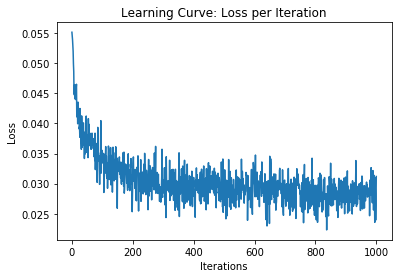

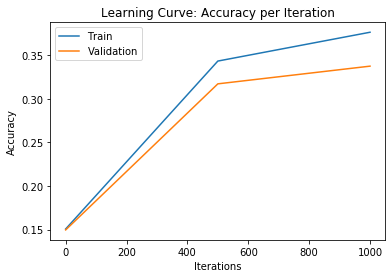

In [0]:
pytorch_mlp = PyTorchMLP()
learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp, learning_rate = 0.008, weight_decay= 0)

# you might want to save the `learning_curve_info` somewhere, so that you can plot
# the learning curve prior to exporting your PDF file

plot_learning_curve(*learning_curve_info)

### Part (e) -- 3 points

Write a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

Start by thinking about what you need to do, step by step, taking
care of the difference between a numpy array and a PyTorch Tensor.

In [0]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[-3:]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos

    x = make_onehot(convert_words_to_indices([sentence[-3:]]))
    y = model(torch.Tensor(x)).detach().numpy()
    return vocab_itos[np.argmax(y)]

make_prediction_torch(pytorch_mlp, ["there", "but", "she"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


'did'

### Part (f) -- 4 points

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense? (If all of your predictions are the same,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%)

One concern you might have is that our model may be "memorizing" information
from the training set.  Check if each of 3-grams (the 3 words appearing next
to each other) appear in the training set. If so, what word occurs immediately
following those three words?

In [0]:
print(make_prediction_torch(pytorch_mlp, ["you", "are", "a"]))
print(make_prediction_torch(pytorch_mlp, ["few", "companies", "show"]))
print(make_prediction_torch(pytorch_mlp, ["there", "are", "no"]))
print(make_prediction_torch(pytorch_mlp, ["yesterday", "i", "was"]))
print(make_prediction_torch(pytorch_mlp, ["the", "game", "had"]))
print(make_prediction_torch(pytorch_mlp, ["yesterday", "the", "federal"]))

def find_in_train(sent):
  preds = []
  for sents in train:
    for j in range(len(sents)):
      if j+3 <len(sents):
        if sents[j:j+3] == sent:
          preds.append(sents[j+3])
  return preds

print(find_in_train(["you", "are", "a"]))
print(find_in_train(["few", "companies", "show"]))
print(find_in_train(["there", "are", "no"]))
print(find_in_train(["yesterday", "i", "was"]))
print(find_in_train(["the", "game", "had"]))
print(find_in_train(["yesterday", "the", "federal"]))

#our outputs makes sense, because it is generalizing our dataset and not just 
#memorizing them and it even gives a solid prediction for the input combibation
#that it has never seen

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


good
up
money
.
to
one
['company', 'family', 'president', 'man', 'man', 'big', 'good', 'man', 'man', 'good', 'what']
[]
['children', 'women', 'children', 'people', 'people']
[]
[]
[]


### Part (g) -- 1 points

Report the test accuracy of your model

In [0]:
# Write your code here
estimate_accuracy_torch(pytorch_mlp, test4grams)

0.3395887694395157

## Question 3. Learning Word Embeddings

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model2.png" />

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.

### Part (a) - 10 pts

Complete the methods in `NumpyWordEmbModel`.

In [0]:
class NumpyWordEmbModel(object):
    def __init__(self, vocab_size=250, emb_size=100, num_hidden=100):
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_hidden = num_hidden
        self.emb_weights = np.zeros([emb_size, vocab_size]) # no biases in this layer
        self.weights1 = np.zeros([num_hidden, emb_size * 3])
        self.bias1 = np.zeros([num_hidden])
        self.weights2 = np.zeros([vocab_size, num_hidden])
        self.bias2 = np.zeros([vocab_size])
        self.num_features = 3 * emb_size
        self.cleanup()

    def initializeParams(self):
        """
        Randomly initialize the weights and biases of this two-layer MLP.
        The randomization is necessary so that each weight is updated to
        a different value.
        """
        self.emb_weights = np.random.normal(0, 2/self.num_hidden, self.emb_weights.shape)
        self.weights1 = np.random.normal(0, 2/self.num_features, self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.num_features, self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden, self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.
        Note that `inputs` will be a rank-3 numpy array with shape [N, 3, 250].


        """
        N0 = inputs.shape[0]
        self.inp0 = inputs[:, 0, :]
        self.inp1 = inputs[:, 1, :]
        self.inp2 = inputs[:, 2, :]

        X0 = np.matmul(inputs[:, 0, :], self.emb_weights.T)
        X1 = np.matmul(inputs[:, 1, :], self.emb_weights.T)
        X2 = np.matmul(inputs[:, 2, :], self.emb_weights.T)
        emp_layer = np.concatenate((X0, X1, X2), axis = 1)

        self.N = N0
        self.X = emp_layer
        self.z1 =  np.matmul(self.X, self.weights1.T) + self.bias1.reshape((1, 100))
        self.h = np.maximum(0, self.z1)
        self.z2 = np.matmul(self.h, self.weights2.T) + self.bias2.reshape((1, 250))
        self.y = softmax(self.z2)
        return self.y

        

    def __call__(self, inputs):
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the groundhi-truth, one-hot targets.
        Note that `ts` needs to be a rank 2 numpy array with shape [N, 250].

        Remember the multivariate chain rule: if a weight affects the loss
        through different paths, then the error signal from all the paths
        must be added together.
        """
        self.z2_bar = (self.y - ts) / self.N
        self.w2_bar = np.dot(self.z2_bar.T, self.h)
        self.b2_bar = np.dot(self.z2_bar.T, np.ones(self.N))
        self.h_bar = np.matmul(self.z2_bar, self.weights2)
        self.z1_bar = self.h_bar * (self.z1 > 0)
        self.w1_bar = np.dot(self.z1_bar.T, self.X)
        self.b1_bar = np.dot(self.z1_bar.T, np.ones(self.N))
        self.wrep_bar = np.dot(self.z1_bar, self.weights1)
        # self.wrep_bar1 = np.dot(self.z1_bar, self.weights1[:,100:200])
        # self.wrep_bar2 = np.dot(self.z1_bar, self.weights1[:,200:])

        self.wemb_bar = (np.dot(self.wrep_bar[:, :100].T, self.inp0)
               + np.dot(self.wrep_bar[:, 100:200].T, self.inp1)
               + np.dot(self.wrep_bar[:, 200:].T, self.inp2))
        
    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        """
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1    = self.bias1    - alpha * self.b1_bar
        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2    = self.bias2    - alpha * self.b2_bar
        self.emb_weights = self.emb_weights - alpha * self.wemb_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        self.N = None
        self.X = None
        self.z1 = None
        self.h = None
        self.z2 = None
        self.y = None
        self.z2_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.h_bar = None
        self.z1_bar = None
        self.w1_bar = None
        self.b1_bar = None
        self.wemb_bar = None
        self.inp0 = None
        self.inp1 = None
        self.inp2 = None

### Part (b) -- 1 pts

One strategy that machine learning practitioners use to debug their code
is to *first try to overfit their model to a small training set*. If the
gradient computation is correct and the data is encoded properly, then your
model should easily achieve 100% training accuracy on a small training set.

Show that your model is implemented correctly by showing that your model
can achieve an 100% training accuracy within a few hundred iterations, when
using a small training set (e.g. one batch).

In [0]:
numpy_wordemb = NumpyWordEmbModel()
numpy_wordemb.initializeParams()
run_gradient_descent(numpy_wordemb, train4grams[:64], batch_size=64, learning_rate = 0.2)

Iter 100. [Val Acc 17%] [Train Acc 16%, Loss 4.271692]
Iter 200. [Val Acc 17%] [Train Acc 16%, Loss 3.487572]
Iter 300. [Val Acc 17%] [Train Acc 16%, Loss 3.421739]
Iter 400. [Val Acc 17%] [Train Acc 16%, Loss 3.402575]
Iter 500. [Val Acc 17%] [Train Acc 16%, Loss 3.364577]
Iter 600. [Val Acc 11%] [Train Acc 22%, Loss 3.036605]
Iter 700. [Val Acc 3%] [Train Acc 33%, Loss 2.564697]
Iter 800. [Val Acc 4%] [Train Acc 50%, Loss 1.957843]
Iter 900. [Val Acc 4%] [Train Acc 84%, Loss 1.042535]
Iter 1000. [Val Acc 4%] [Train Acc 100%, Loss 0.431271]
Iter 1100. [Val Acc 4%] [Train Acc 100%, Loss 0.175193]
Iter 1200. [Val Acc 4%] [Train Acc 100%, Loss 0.084053]
Iter 1300. [Val Acc 4%] [Train Acc 100%, Loss 0.047827]
Iter 1400. [Val Acc 4%] [Train Acc 100%, Loss 0.030787]
Iter 1500. [Val Acc 4%] [Train Acc 100%, Loss 0.021934]
Iter 1600. [Val Acc 4%] [Train Acc 100%, Loss 0.016776]
Iter 1700. [Val Acc 4%] [Train Acc 100%, Loss 0.013445]
Iter 1800. [Val Acc 4%] [Train Acc 100%, Loss 0.011139]
Iter

### Part (c) -- 2 pts

Train your model from part (a) to obtain a training accuracy of at least 25%.

In [0]:
# Your code goes here
run_gradient_descent(numpy_wordemb, learning_rate = 0.3)

Iter 100. [Val Acc 19%] [Train Acc 20%, Loss 4.184597]
Iter 200. [Val Acc 22%] [Train Acc 23%, Loss 3.973731]
Iter 300. [Val Acc 24%] [Train Acc 25%, Loss 3.787526]
Iter 400. [Val Acc 25%] [Train Acc 25%, Loss 3.499964]
Iter 500. [Val Acc 25%] [Train Acc 26%, Loss 3.582619]
Iter 600. [Val Acc 26%] [Train Acc 27%, Loss 3.756810]
Iter 700. [Val Acc 26%] [Train Acc 27%, Loss 3.576100]
Iter 800. [Val Acc 26%] [Train Acc 27%, Loss 3.462031]
Iter 900. [Val Acc 27%] [Train Acc 27%, Loss 3.277631]
Iter 1000. [Val Acc 27%] [Train Acc 28%, Loss 3.540488]
Iter 1100. [Val Acc 27%] [Train Acc 28%, Loss 3.552578]
Iter 1200. [Val Acc 28%] [Train Acc 28%, Loss 3.136311]
Iter 1300. [Val Acc 28%] [Train Acc 28%, Loss 3.246445]
Iter 1400. [Val Acc 28%] [Train Acc 28%, Loss 3.088345]
Iter 1500. [Val Acc 28%] [Train Acc 28%, Loss 3.585413]
Iter 1600. [Val Acc 28%] [Train Acc 29%, Loss 3.193283]
Iter 1700. [Val Acc 28%] [Train Acc 29%, Loss 3.166561]
Iter 1800. [Val Acc 29%] [Train Acc 29%, Loss 3.316647]
I

### Part (d) -- 2 pts

The PyTorch version of the model is implemented for you. Use 
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

Make sure that you checkpoint frequently. We will be using ...

Iter 0. [Val Acc 17%] [Train Acc 17%, Loss 5.510087]
Iter 500. [Val Acc 27%] [Train Acc 27%, Loss 3.397268]
Iter 1000. [Val Acc 29%] [Train Acc 30%, Loss 2.814312]
Iter 1500. [Val Acc 30%] [Train Acc 31%, Loss 3.025668]
Iter 2000. [Val Acc 31%] [Train Acc 31%, Loss 2.624730]
Iter 2500. [Val Acc 32%] [Train Acc 33%, Loss 2.737919]
Iter 3000. [Val Acc 33%] [Train Acc 33%, Loss 3.020097]
Iter 3500. [Val Acc 33%] [Train Acc 34%, Loss 2.945531]
Iter 4000. [Val Acc 34%] [Train Acc 34%, Loss 2.654337]
Iter 4500. [Val Acc 34%] [Train Acc 35%, Loss 2.999660]
Iter 5000. [Val Acc 35%] [Train Acc 36%, Loss 3.006204]
Iter 5500. [Val Acc 34%] [Train Acc 35%, Loss 3.111285]
Iter 6000. [Val Acc 35%] [Train Acc 36%, Loss 2.574912]
Iter 6500. [Val Acc 35%] [Train Acc 36%, Loss 2.937150]
Iter 7000. [Val Acc 35%] [Train Acc 35%, Loss 2.622247]
Iter 7500. [Val Acc 35%] [Train Acc 36%, Loss 2.759908]
Iter 8000. [Val Acc 36%] [Train Acc 37%, Loss 2.651202]
Iter 8500. [Val Acc 36%] [Train Acc 37%, Loss 2.8484

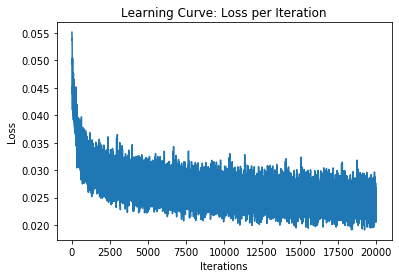

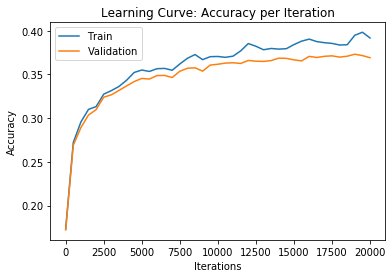

In [0]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)

pytorch_wordemb= PyTorchWordEmb()

result = run_pytorch_gradient_descent(pytorch_wordemb,
                                       max_iters=20000)

plot_learning_curve(*result)

### Part (e) -- 2 pts

Use the function `make_prediction` that you wrote earlier to  
predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

Just like before, if all of your predictions are the same,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [0]:
print(make_prediction_torch(pytorch_wordemb, ["you", "are", "a"]))
print(make_prediction_torch(pytorch_wordemb, ["few", "companies", "show"]))
print(make_prediction_torch(pytorch_wordemb, ["there", "are", "no"]))
print(make_prediction_torch(pytorch_wordemb, ["yesterday", "i", "was"]))
print(make_prediction_torch(pytorch_wordemb, ["the", "game", "had"]))
print(make_prediction_torch(pytorch_wordemb, ["yesterday", "the", "federal"]))

def find_in_train(sent):
  preds = []
  for sents in train:
    for j in range(len(sents)):
      if j+3 <len(sents):
        if sents[j:j+3] == sent:
          preds.append(sents[j+3])
  return preds

print(find_in_train(["you", "are", "a"]))
print(find_in_train(["few", "companies", "show"]))
print(find_in_train(["there", "are", "no"]))
print(find_in_train(["yesterday", "i", "was"]))
print(find_in_train(["the", "game", "had"]))
print(find_in_train(["yesterday", "the", "federal"]))


#the predictions of this model seem to be more meaningful.
#and this time around our model picks words that are more often 
#repeated for the examples existing in our training set.
#but it stills generalizes good for the combination of words it never seen before

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


man
up
other
nt
to
government
['company', 'family', 'president', 'man', 'man', 'big', 'good', 'man', 'man', 'good', 'what']
[]
['children', 'women', 'children', 'people', 'people']
[]
[]
[]


### Part (f) -- 1 pts

Report the test accuracy of your model

In [0]:
# Write your code here
accuracy = str(int(estimate_accuracy_torch(pytorch_wordemb, test4grams) * 100))

print("the acuracy for the model on test is: "+ accuracy +"%")

the acuracy for the model on test is: 37%


## Question 4. Visualizing Word Embeddings

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings.

### Part (a) -- 2 pts

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [0]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T
# Write your explanation here

#that is because of the fact that the word_emb contains word representaion
#of every word in our vocab, so when given an index of an word to the word_emb
#we expect a vector which represents this word in our vocab. 

### Part (b) -- 2 pts

Once interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the cosine similarity of
every pair of words in our vocabulary. This code should look familiar,
since we have seen it in project 1.

In [0]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.40344852
-0.053034283


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [0]:
#TODO
words = ['four', 'go', 'what', 'should', 'school', 'your', 'yesterday', 'not']
def compute_k_closest(i, k):
   closests = sorted(enumerate(similarities[:, i]),
                      key=lambda r: r[1],
                      reverse=True)
   closest_indices = [index for (index, dist) in closests[:k]]
   words = []
   for i in closest_indices:
     words.append(vocab_itos[i])
   return words

k_closests = []
k = 6
for word in words:
  index = vocab_stoi[word]
  k_closests = compute_k_closest(index, k)
  print("closest words to '"+word+"' : "+' '.join(k_closests))

closest words to 'four' : four three two five years more
closest words to 'go' : go going come back up percent
closest words to 'what' : what where when who how which
closest words to 'should' : should could would can big will
closest words to 'school' : school ) another center york before
closest words to 'your' : your my their its our of
closest words to 'yesterday' : yesterday john today house money year
closest words to 'not' : not nt states might still used


### Part (c) -- 2 pts

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment,
but we may cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.
Look at the plot and find two clusters of related words.
What do the words in each cluster have in common?

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file for your TA to see.

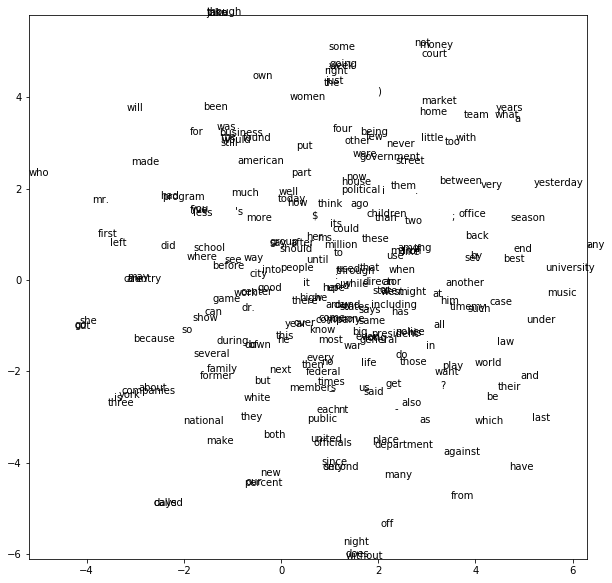

In [0]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

#the words in each cluster are related to each other and they mostly
#either have similar characters or they are close in the meaning to each other.
#for example numbers have their own cluster because of their meaning relation.